target D1, 73.41619197935188
target D2, 146.8323839587038
abc


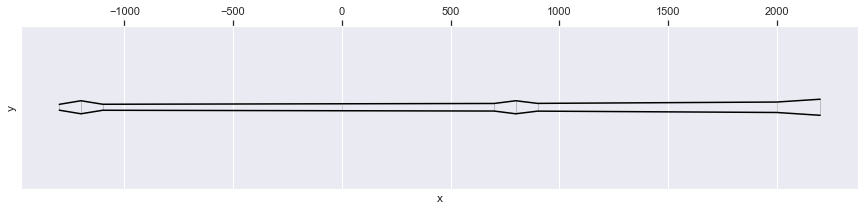

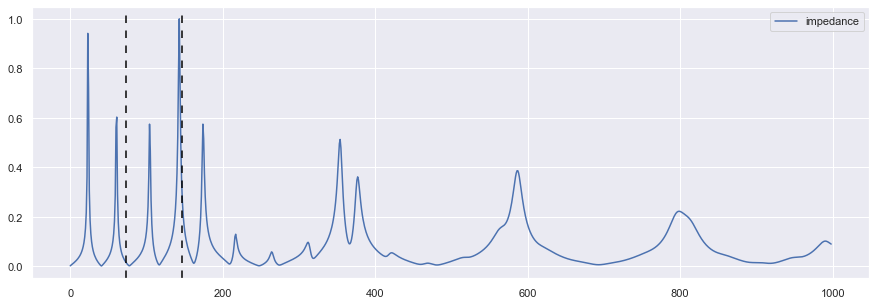

[[0, 32], [700.0, 34.8], [800, 60], [900.0, 35.6], [-1300.0, 26.8], [-1200, 60], [-1100.0, 27.6], [2000, 48], [2200, 74]]


In [34]:
from cad.calc.geo import Geo
from cad.calc.didgmo import PeakFile, didgmo_bridge
from cad.calc.visualization import DidgeVisualizer, FFTVisualiser
import matplotlib.pyplot as plt
from cad.calc.conv import note_to_freq, note_name
from IPython.display import clear_output
import math
import random
import copy

shape=[
    [0, 32], 
    [600, 32], 
    [700, 50], 
    [800, 40], 
    [1150, 40], 
    [1250, 60], 
    [1350, 42], 
    [1700, 45], 
    [1800, 65], 
    [1900, 70], 
    [2000, 75]
]


def loss(target, peak):
    l=0.0
    for i in range(len(target)):
        l1 = target[i] - peak.impedance_peaks[i]["freq"]
        l+=l1*l1
    return l


class BubbleGeo:
    
    def __init__(self, l, d_mund, d_before_bell, d_bell, l_bell):
        self.l=l
        self.d_mund=d_mund
        self.d_bell=d_bell
        self.d_before_bell=d_before_bell
        self.l_bell=l_bell
        self.bubbles=[]
        
    def add_bubble(self, pos, width, height):
        self.bubbles.append({
            "pos": pos,
            "width": width,
            "height": height
        })
        self.bubbles.sort(key=lambda x : x["pos"])
        
    def make_geo(self):
        shape=[[0, self.d_mund]]
        
        gk=(self.d_before_bell-self.d_mund)/2
        winkel=math.atan(gk/self.l)
        
        for bubble in self.bubbles:
            x1=bubble["pos"]-bubble["width"]/2
            y1=self.d_mund + math.tan(winkel)*x1
            x3=bubble["pos"]+bubble["width"]/2
            y3=self.d_mund + math.tan(winkel)*x3
            
            shape.append([x1,y1])
            shape.append([bubble["pos"],bubble["height"]])
            shape.append([x3, y3])
        
        shape.append([self.l, self.d_before_bell])
        shape.append([self.l + self.l_bell, self.d_bell])
        
        return Geo(geo=shape)
    
    def copy(self):
        cop=BubbleGeo(self.l, self.d_mund, self.d_before_bell, self.d_bell, self.l_bell)
        cop.bubbles=copy.deepcopy(self.bubbles)
        return copy
    
    def reorder(self):
        if len(self.bubbles)==0:
            return
            
        b0=self.bubbles[0]
        
        if b0["pos"]-b0["width"]/2<0:
            b0["width"] = b0["pos"]*2
        
        for i in range(0, len(self.bubbles)-1):
            b0=self.bubbles[i]
            b1=self.bubbles[i+1]
            
            if b0["pos"]+b0["width"]/2 > b1["pos"]-b1["width"]/2:
                b0["width"]=(b1["pos"]-b0["pos"])*2
        
        
        
def visualize_evolution(geo, peak, fft, target):

    #print(shape)
    DidgeVisualizer.vis_didge(geo)
    plt.show()

    FFTVisualiser.vis_fft_and_target(fft, target)

    plt.show()

target=[-31, -19]

for t in target:
    freq=note_to_freq(t)
    name=note_name(t)
    print(f"target {name}, {freq}")
target=[note_to_freq(x) for x in target]


class Evolver:
    
    def __init__(self):
        self.operations=[]
        
    def mutate(self, operation, f, learning_rate=1.0):
        pass
    
    def get_random_operation(self):
        return self.operations[random.randint(0, len(self.operations)-1)]

class BubbleEvolver(Evolver):
    
    def __init__(self):
        self.operations=["change_pos", "change_height", "change_width"]
        
    def mutate(self, operation, f, learning_rate=1.0):
        
        i_bubble=random.randint(0, len(f.bubbles)-1)
        factor=1.0+((random.random()-0.5)* learning_rate)
        
        factor=-1
        i_bubble=1
        
        old_bubble=f.bubbles[i_bubble]
        
        if operation=="change_pos":
            f.bubbles[i_bubble]["pos"] *= factor
        elif operation=="change_height":
            f.bubbles[i_bubble]["height"] *= factor
        elif operation=="change_width":
            f.bubbles[i_bubble]["width"] *= factor
        else:
            raise Exception(f"unknown operation {operation}")
                        
        return f
                  
father=BubbleGeo(2000, 32, 48, 74, 200)
father.add_bubble(800, 200, 60)
father.add_bubble(1200, 200, 60)
evolver=BubbleEvolver()
mutant=evolver.mutate("change_pos", father.copy())
geo=mutant.make_geo()
peak, fft=didgmo_bridge(geo)
visualize_evolution(geo, peak, fft, target)
print(geo.geo)

In [ ]:

evolver=BubbleEvolver()
best_loss=None

for i in range(2000):

    mutant=evolver.mutate(evolver.get_random_operation(), father.copy())
    geo=mutant.make_geo()
    peak, fft=didgmo_bridge(geo)
    l=loss(target, peak)
    if best_loss==None or l<best_loss:
        father=mutant    
        clear_output(wait=True)
        visualize_evolution(geo, peak, fft, target)
        best_loss=l

In [ ]:
import random
from tqdm import tqdm

shape=[
    [0, 32], 
    [600, 32], 
    [700, 50], 
    [800, 40], 
    [1150, 40], 
    [1250, 60], 
    [1350, 42], 
    [1700, 45], 
    [1800, 65], 
    [1900, 70], 
    [2000, 75]
]

target=[-31, -19]
for t in target:
    freq=note_to_freq(t)
    name=note_name(t)
    print(f"target {name}, {freq}")
target=[note_to_freq(x) for x in target]

geo=Geo(geo=shape)

c=0
n_iterations=1000
loss=1000000
visualize_evolution(geo, peak, fft, target)
with tqdm(total=n_iterations) as pbar:
    
    for i in range(n_iterations):
        
        try:
            mutation_operation=mutation_operations[random.randint(0, len(mutation_operations)-1)]
            mutant=mutate(geo, mutation_operation)
            peak, fft=didgmo_bridge(mutant)
            mutant_loss=loss_overblow_freqs(peak, target)

            if mutant_loss < loss:
                loss=mutant_loss
                geo=mutant
                clear_output(wait=True)
                visualize_evolution(geo, peak, fft, target)
                peak.print_impedance_peaks()
        except Exception:
            pass

        pbar.update(1)
        pbar.set_description(f"iteration={i}, loss={loss}")


In [24]:
mutation_operations=["change_length", "change_segment_diameter", "change_segment_position"]

def loss_overblow_freqs(peak, target):
    loss=0
    for i in range(len(target)):
        loss += abs(target[i] - peak.impedance_peaks[i]["freq"])
    return loss   

def mutate(geo, operation, learning_rate):

    if operation=="change_length":
        factor=0.95+(random.random()/10)*learning_rate
        geo.stretch(factor)
        
    elif operation=="change_segment_diameter":
        factor=0.75+(random.random()/50)*learning_rate
        segment=random.randint(0, len(geo.geo)-1)
        
        if segment==0:
            return mutate(geo, operation)
        geo.geo[segment][1]*=factor
        
    elif operation=="change_segment_position":
        factor=0.75+(random.random()/50)*learning_rate
        segment=random.randint(0, len(geo.geo)-1)
        geo.geo[segment][0]*=factor
        
    else:
        raise Exception("unknown operation " + str(operatino))
        
    return geo

def evolve(geo, target):
    
    generation_size=10
    n_generations=100
    mutation_operations=["change_length", "change_segment_diameter", "change_segment_position"]
    
    peak, fft=didgmo_bridge(geo)
    father_loss=loss_overblow_freqs(peak, target)
    
    best_loss=father_loss
    best_geo=geo
    
    DidgeVisualizer.vis_didge(geo)
    FFTVisualiser.vis_fft_and_target(fft, target)
    return
    
    with tqdm(total=n_generations*generation_size, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}') as pbar:

        for i_gen in range(n_generations):

            loss_before_mutate=best_loss
            for i_mutant in range(generation_size):
                mutation_operation=mutation_operations[random.randint(0, len(mutation_operations)-1)]
                mutant=geo.copy()
                mutant=mutate(mutant, mutation_operation)
                peak=didgmo_bridge(mutant, skip_fft=True)
                
                #peak.print_impedance_peaks()

                
                mutant_loss=loss_overblow_freqs(peak, target)
                if mutant_loss<best_loss:
                    best_geo=mutant
                    best_loss=mutant_loss

                p=i_gen*generation_size + i_mutant
                pbar.update(1)
                pbar.set_description(f"generation={i_gen}, loss={best_loss:.2f}, loss_diff={loss_before_mutate-best_loss}")
            loss_diff=loss_before_mutate-best_loss        
    return best_geo

